In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.seasonal import seasonal_decompose
# our python file with functions
import altedc as altedc

In [3]:
data_path = 'data/'
data = pd.read_csv(f'{data_path}train_phase_1.csv')
data.date = pd.to_datetime(data.date, format='%Y-%m-%d %H:%M:%S')
test = pd.read_csv(f'{data_path}test_phase_1.csv')
test.date = pd.to_datetime(test.date, format='%Y-%m-%d %H:%M:%S')

In [4]:
data.shape, test.shape

((18756, 6), (7488, 5))

In [5]:
assert data.dtypes.equals(pd.Series({
    'date': 'datetime64[ns]', 
    'wp1': 'float64', 
    'u': 'float64', 
    'v': 'float64', 
    'ws': 'float64', 
    'wd': 'float64',
}))

assert test.dtypes.equals(pd.Series({
    'date': 'datetime64[ns]', 
    'u': 'float64', 
    'v': 'float64', 
    'ws': 'float64', 
    'wd': 'float64',
}))

In [6]:
assert not data.isnull().any(axis=None) and not test.isnull().any(axis=None)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [8]:
train, val = train_test_split(data, test_size=0.2, shuffle=True)
print(train.shape, val.shape)

(15004, 6) (3752, 6)


In [9]:
X_train = train['ws'].values.reshape((-1, 1))
y_train = train['wp1'].values

X_val = val['ws'].values.reshape((-1, 1))
y_val = val['wp1'].values

lm = LinearRegression()
lm.fit(X_train, y_train)
mean_absolute_error(lm.predict(X_val), y_val)

0.13213274499971295

In [10]:
from sklearn.dummy import DummyRegressor
dm = DummyRegressor(strategy='mean')
dm.fit(X_train, y_train)
print(mean_absolute_error(dm.predict(X_val), y_val))

dm = DummyRegressor(strategy='median')
dm.fit(X_train, y_train)
print(mean_absolute_error(dm.predict(X_val), y_val))

0.200902640319369
0.19495255863539446


In [11]:
from sklearn.ensemble import RandomForestRegressor
X_train = train[['ws', 'wd', 'u', 'v']].values
y_train = train['wp1'].values

X_val = val[['ws', 'wd', 'u', 'v']].values
y_val = val['wp1'].values

rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train, y_train)
print(mean_absolute_error(rf.predict(X_val), y_val))

0.1290526935856432


In [12]:
#make new features
df_copy = altedc.create_features_train(train)
df_copy_val = altedc.create_features_val(val)
df_copy_test = altedc.create_features_test(test)

/home/ec2-user/SageMaker/git/data_challenge/Data-Challenge-Starter-Kit/altedc.py:66: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_copy['wk']=df_copy.date.dt.week
/home/ec2-user/SageMaker/git/data_challenge/Data-Challenge-Starter-Kit/altedc.py:130: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  wavh_copy=df_copy.groupby([df_copy['date'].dt.week])['vh'].mean().to_dict()
/home/ec2-user/SageMaker/git/data_challenge/Data-Challenge-Starter-Kit/altedc.py:131: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_copy['wavh']=df_copy['date'].dt.week.replace(wavh_copy)
/home/ec2-user/SageMaker/git/data_challenge/Data-Challenge-Starter-Kit/altedc.py:138: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.i

In [13]:
cols=['u', 'v', 'ws', 'wd', 'wva', 'mwd', 'vh', 'hr', 'mo', 'dy', 'wk', 'qr', 'doy', 'dow', 'yr', 'u_z', 'v_z', 'ws_z', 'wd_z', 'wsq', 'wdc', 'wvac', 'mwdc','rwd', 'u*v',  'wsr', 'ws100m', 'ws3', 'wpe','pa','vh3','daws','davh','year_sin','year_cos','month_sin', 'month_cos', 'quarter_sin', 'quarter_cos','semester_sin',
       'semester_cos', 'twowk_sin', 'twowk_cos', 'week_sin', 'week_cos', 'twomonth_sin', 'twomonth_cos', 'fourmonth_sin',
       'fourmonth_cos', 'fivemonth_sin', 'fivemonth_cos',
       'sevenmonth_sin', 'sevenmonth_cos', 'ninemonth_sin', 'ninemonth_cos', 'thirteenmonth_cos', 'elevenmonth_cos','fivemonth_sin','sevenmonth_sin', 'sixteenmonth_cos','ti','vhi','uv_dir', 'wswdsin','wswdcos','twoday_sin','twoday_cos','tid','gust','dmws',#'wd_ns','wd_ew','wd_avg' ,'wsh_max','vhi_max','ws_diff','vhi_diff','ti_diff' #,'hmws' #, 'tiv', #'vhiv'#'gusti'#,'dwd', 'dti','pai','dvh','dpa'
     # 'pai','vhpa'
  
     ] # 'vhpa' ,'vhid','paid', 'pai', 'haws', 'dmvh','dpa'

In [14]:
len(cols)

70

In [14]:
#Try RF on additional features
from sklearn.ensemble import RandomForestRegressor
X_train = df_copy[cols].values #'wva', 'mwd',
y_train = df_copy['wp1'].values

X_val = df_copy_val[cols].values #'wva', 'mwd',
y_val = df_copy_val['wp1'].values

rf = RandomForestRegressor(bootstrap=False, max_depth=25, max_features=12,
                      n_estimators=2000, n_jobs=-1)
rf.fit(X_train, y_train)
print(mean_absolute_error(rf.predict(X_val), y_val)) #min_samples_split =2, min_samples_leaf =1, max_depth=20, max_features=10, 0.06642867238363016, 
# 0.06682952159550563 0.06961529322707194 0.06871897093902136 bootstrap false, max depth 25, max features 12, n_estimators 2000

0.06768425596517569


In [14]:
#predictions on test set with RF and additional features
X_test = df_copy_test[cols].values

df_predictions = pd.DataFrame({
    'date': df_copy_test['date'],
    'wp1': rf.predict(X_test),
})

df_predictions.to_csv(r'predictions.csv', index=False, sep=';')
df_predictions.head()

,date,wp1
0,2011-01-01 01:00:00,0.507778
1,2011-01-01 02:00:00,0.424686
2,2011-01-01 03:00:00,0.425287
3,2011-01-01 04:00:00,0.426112
4,2011-01-01 05:00:00,0.427032


In [15]:
!pip3 install xgboost

     |████████████████████████████████| 166.7 MB 22 kB/s s eta 0:00:01


In [16]:
import xgboost as xgb
X_train = df_copy[cols].values #'wva', 'mwd',,'u*v','rwd'
y_train = df_copy['wp1'].values

X_val = df_copy_val[cols].values #'wva', 'mwd',,'u*v','rwd'
y_val = df_copy_val['wp1'].values

xgb = xgb.XGBRegressor(random_state=0)
xgb.fit(X_train, y_train)
print(mean_absolute_error(xgb.predict(X_val), y_val))

0.07290120074089664


In [17]:
!pip install lightgbm

In [18]:
import lightgbm as lgb
X_train = df_copy[cols].values #'wva', 'mwd',
y_train = df_copy['wp1'].values

X_val = df_copy_val[cols].values #'wva', 'mwd',
y_val = df_copy_val['wp1'].values

lgbm = lgb.LGBMRegressor(objective="tweedie",max_depth=15,num_leaves=80,num_iterations=2500,learning_rate=0.01,min_data_in_leaf=100, min_sum_hessian_in_leaf=10, feature_fraction=0.6)
lgbm.fit(X_train, y_train)
print(mean_absolute_error(lgbm.predict(X_val), y_val))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
0.06820459544684371


In [19]:
#bagging regressor
from sklearn.ensemble import BaggingRegressor

X_train = df_copy[cols].values #'wva', 'mwd',,'u*v','rwd'
y_train = df_copy['wp1'].values

X_val = df_copy_val[cols].values #'wva', 'mwd',,'u*v','rwd'
y_val = df_copy_val['wp1'].values

br = BaggingRegressor(random_state=0,bootstrap=False, n_estimators=2000, max_features=25, max_samples=0.5)
br.fit(X_train, y_train)
print(mean_absolute_error(br.predict(X_val), y_val))

0.07716929997334773


In [ ]:
#RF feature importances
rf.feature_importances_

Text(0.5, 0, 'Random Forest Feature Importance')

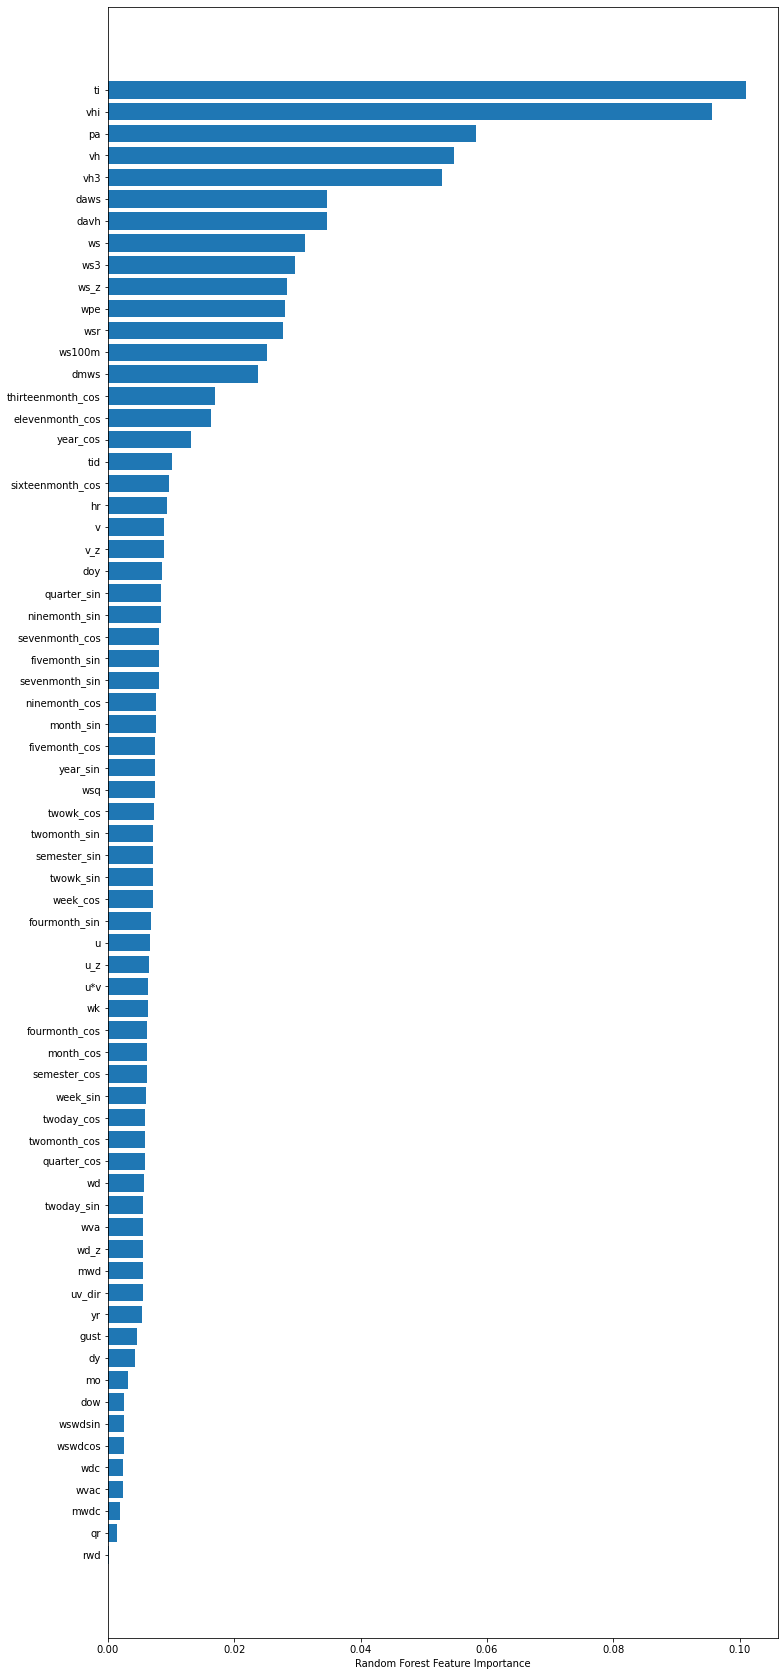

In [15]:
plt.rcParams.update({'figure.figsize': (12,30)})
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df_copy[cols].columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [16]:
!pip3 install --upgrade pip
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install scikit-learn
!pip3 install keras
!pip3 install tensorflow

     |████████████████████████████████| 1.5 MB 23.4 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1
     |██████████████████████▋         | 321.5 MB 136.1 MB/s eta 0:00:01   |█▏                              | 16.7 MB 22.1 MB/s eta 0:00:20     |██████▎                         | 89.4 MB 22.1 MB/s eta 0:00:17     |███████████████▌                | 220.5 MB 78.8 MB/s eta 0:00:03

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 454.3 MB 11 kB/s /s eta 0:00:01     |██████████████████████████████▌ | 433.0 MB 101.1 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 5.9 MB/s s eta 0:00:01
     |████████████████████████████████| 6.0 MB 62.5 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 4.0 MB 90.9 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 86.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 75.1 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 93.8 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 82.8 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 88.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 105.3 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 67.5 MB/s eta 0:00:01
     |████████████████████████

In [14]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import tensorflow as tf
import keras
from keras.models import Input, Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Conv1D, Flatten, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy.random import seed
seed(100)
tf.random.set_seed(100)

In [15]:
df=data.copy()

In [16]:
df_cols= df.columns.to_list()

In [17]:
# Define the features that will be used for training
train_columns = df_cols[1:]
# Get only the train_columns part of pandas 
# Call split_data function  and print the shape of each set
df_train, df_val, df_test = altedc.split_data(df[train_columns])
print('Train \n', df_train)
print('Val \n', df_val)
print('Test \n', df_test)

Train 
          wp1     u     v    ws      wd
0      0.085  2.34 -0.79  2.47  108.68
1      0.020  2.18 -0.99  2.40  114.31
2      0.060  2.20 -1.21  2.51  118.71
3      0.045  2.35 -1.40  2.73  120.86
4      0.035  2.53 -1.47  2.93  120.13
...      ...   ...   ...   ...     ...
15000  0.105 -1.38  2.52  2.88  331.25
15001  0.160 -1.75  2.28  2.87  322.58
15002  0.281 -1.96  2.41  3.11  320.92
15003  0.381 -1.98  2.80  3.43  324.75
15004  0.356 -1.69  3.30  3.70  332.90

[15005 rows x 5 columns]
Val 
          wp1     u     v    ws      wd
15005  0.266 -0.97  3.77  3.89  345.62
15006  0.306  0.23  4.10  4.11    3.26
15007  0.311  1.68  4.24  4.56   21.61
15008  0.271  3.05  4.13  5.14   36.45
15009  0.231  4.11  3.80  5.60   47.25
...      ...   ...   ...   ...     ...
16876  0.852  4.01  4.67  6.15   40.67
16877  0.822  3.96  4.69  6.14   40.18
16878  0.832  3.80  4.35  5.78   41.13
16879  0.747  3.56  3.82  5.22   42.93
16880  0.687  3.24  3.31  4.63   44.35

[1876 rows x 5 columns]

In [18]:
# Transform pandas to numpy arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

print('Train data has shape', np.shape(train_data))
print('Validation data has shape', np.shape(val_data))
print('Test data has shape', np.shape(test_data))

Train data has shape (15005, 5)
Validation data has shape (1876, 5)
Test data has shape (1875, 5)


In [19]:
# Feature Scaling using Min-Max Scaler
# Use fit_transform for train_data and transform for val, test data
scaler = MinMaxScaler(feature_range = (0, 1))
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

In [20]:
# Set the desirable history for creating samples from the time-series
seq_len = 20
ahead = 1
X_train, y_train = altedc.create_supervised_data(train_data, seq_len=seq_len, ahead=ahead)
print('X_train shape is ', np.shape(X_train))
print('y_train shape is ', np.shape(y_train))

X_val, y_val = altedc.create_supervised_data(val_data, seq_len=seq_len, ahead=ahead)
print('X_val shape is ', np.shape(X_val))
print('y_val shape is ', np.shape(y_val))

X_test, y_test = altedc.create_supervised_data(test_data, seq_len=seq_len, ahead=ahead)
print('X_test shape is ', np.shape(X_test))
print('y_test shape is ', np.shape(y_test))

X_train shape is  (14985, 20, 5)
y_train shape is  (14985, 1)
X_val shape is  (1856, 20, 5)
y_val shape is  (1856, 1)
X_test shape is  (1855, 20, 5)
y_test shape is  (1855, 1)


In [21]:
keras.backend.clear_session()
seed(100)
tf.random.set_seed(100)

In [22]:
model = altedc.create_model(np.shape(X_train)[1], np.shape(X_train)[2])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = altedc.compile_and_fit(model, X_train, y_train, X_val, y_val, patience=10)

Epoch 1/100
469/469 [==============================] - 17s 9ms/step - loss: 0.0323 - mean_absolute_error: 0.1632 - val_loss: 0.0125 - val_mean_absolute_error: 0.0986
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0103 - mean_absolute_error: 0.0937 - val_loss: 0.0093 - val_mean_absolute_error: 0.0834
Epoch 3/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0076 - mean_absolute_error: 0.0810 - val_loss: 0.0083 - val_mean_absolute_error: 0.0757
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0068 - mean_absolute_error: 0.0743 - val_loss: 0.0081 - val_mean_absolute_error: 0.0710
Epoch 5/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0701 - val_loss: 0.0085 - val_mean_absolute_error: 0.0679
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0673 - val_loss: 0.0080 - val_mean_absolute_error: 0.0659
Epoch 7/1

In [25]:
def print_metrics_model(X_train, y_train, X_val, y_val, X_test, y_test):
    print('Evaluation metrics')
    print(
        'Training Data - MSE Loss: {:.8f}, MAE Loss: {:.8f}'.format(
                                                    model.evaluate(X_train, y_train, verbose=0)[0], 
                                                    model.evaluate(X_train, y_train, verbose=0)[1]))
    print(
        'Validation Data - MSE Loss: {:.8f}, MAE Loss: {:.8f}'.format(
                                                    model.evaluate(X_val, y_val, verbose=0)[0],
                                                    model.evaluate(X_val, y_val, verbose=0)[1]))
    print(
        'Test Data - MSE Loss: {:.8f}, MAE Loss: {:.8f}'.format(
                                                    model.evaluate(X_test, y_test, verbose=0)[0],
                                                    model.evaluate(X_test, y_test, verbose=0)[1]))
    return

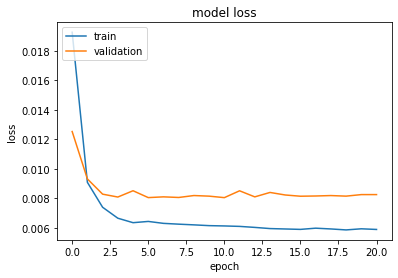

Evaluation metrics
Training Data - MSE Loss: 0.00535815, MAE Loss: 0.05681929
Validation Data - MSE Loss: 0.00825417, MAE Loss: 0.05667001
Test Data - MSE Loss: 0.01056470, MAE Loss: 0.05674267


In [26]:
altedc.plot_loss(history)
print_metrics_model(X_train, y_train, X_val, y_val, X_test, y_test)

(1855, 1)


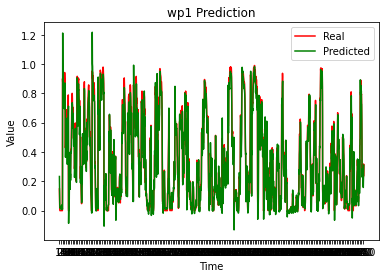

In [27]:
predictions = model.predict(X_test)
print(predictions.shape)
altedc.plot_predictions_test(y_test.squeeze(), predictions)

In [28]:
print('Real mse on test', mean_squared_error(y_test.squeeze(),predictions))

Real mse on test 0.010564701861848526


In [29]:
model.save('model.h5')